In [1]:
!pip install disarray

In [2]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import disarray

In [3]:
def count_jpg_files(root_dir):
    """
    Count all .jpg files in the given directory and its subdirectories
    
    Args:
        root_dir (str): Path to the root directory to start searching from
        
    Returns:
        int: total count
    """
    total_count = 0
    dir_counts = {}
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count jpg files in current directory
        jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
        total_count += jpg_count
    
    return total_count

In [4]:
train_path = '/kaggle/input/multiclassbtsegmentedimages/segmented_bt/train_directory'
validation_path = '/kaggle/input/multiclassbtsegmentedimages/segmented_bt/validation_directory'
test_path = '/kaggle/input/multiclassbtsegmentedimages/segmented_bt/test_directory'

In [5]:
preprocess_input = tensorflow.keras.applications.mobilenet_v2.preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(validation_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

test_image_gen = image_gen.flow_from_directory(test_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

print(test_image_gen.class_indices)

Found 36927 images belonging to 7 classes.
Found 883 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [7]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))
    return f1_score_value

In [10]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy, precision, recall, f1_score])

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.5,
    patience=3,        
    mode='max',
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,       
    mode='min',
    restore_best_weights=True,
    verbose=1
)

model_chkpt = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [12]:
total_samples = sum([5115, 5950, 5990, 5462, 5510, 4810, 4090])
class_weights = {
    0: total_samples / 5510,
    1: total_samples / 5462,
    2: total_samples / 5990,
    3: total_samples / 4090,
    4: total_samples / 5950,
    5: total_samples / 5115,
    6: total_samples / 4810
}

In [13]:
history = tl_model.fit(train_image_gen,
                       epochs=30, 
                       validation_data = val_image_gen,
                       class_weight=class_weights,
                       callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - categorical_accuracy: 0.4877 - f1_score: 0.4013 - loss: 11.6264 - precision: 0.6690 - recall: 0.2991 - top_2_accuracy: 0.6774 - top_3_accuracy: 0.7967
Epoch 1: val_categorical_accuracy improved from -inf to 0.78369, saving model to best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 404s 614ms/step - categorical_accuracy: 0.4878 - f1_score: 0.4015 - loss: 11.6234 - precision: 0.6691 - recall: 0.2993 - top_2_accuracy: 0.6776 - top_3_accuracy: 0.7968 - val_categorical_accuracy: 0.7837 - val_f1_score: 0.7626 - val_loss: 2.8117 - val_precision: 0.8399 - val_recall: 0.7059 - val_top_2_accuracy: 0.8901 - val_top_3_accuracy: 0.9275 - learning_rate: 1.0000e-04
Epoch 2/30
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - categorical_accuracy: 0.7024 - f1_score: 0.6867 - loss: 7.2913 - precision: 0.8017 - recall: 0.6022 - top_2_accuracy: 0.8744 - top_3_accuracy: 0.9461
Epoch 2: val_categorical_accuracy improved from 0.78369 to 0.79728, saving model to best_model

In [14]:
tl_model.save('val_loss_epoch.keras')

<Axes: >

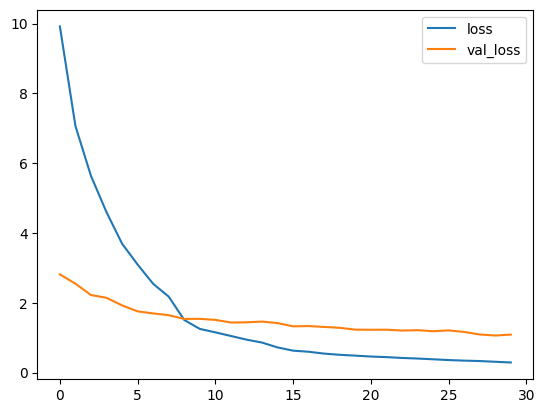

In [15]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

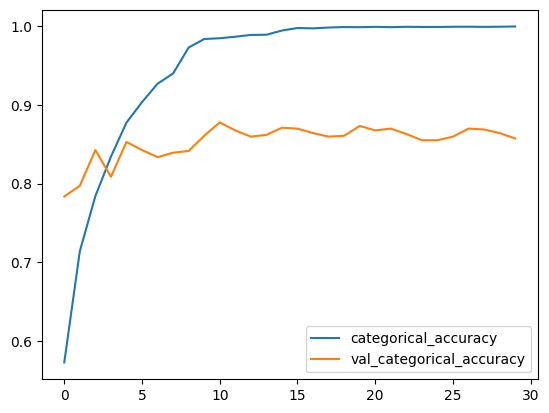

In [16]:
metrics[["categorical_accuracy","val_categorical_accuracy"]].plot()

<Figure size 640x480 with 0 Axes>

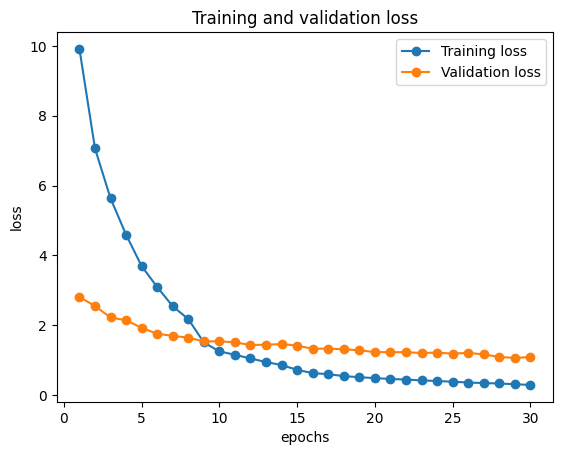

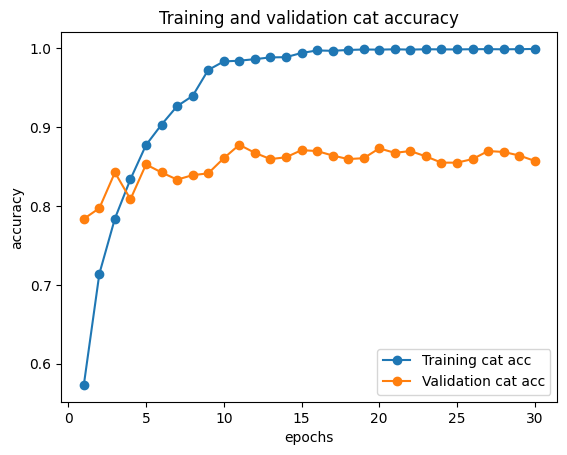

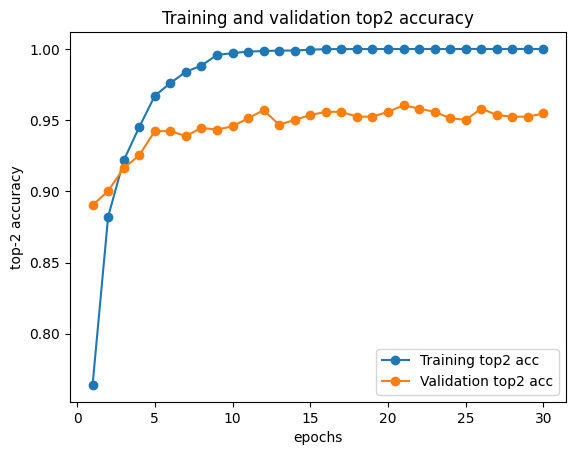

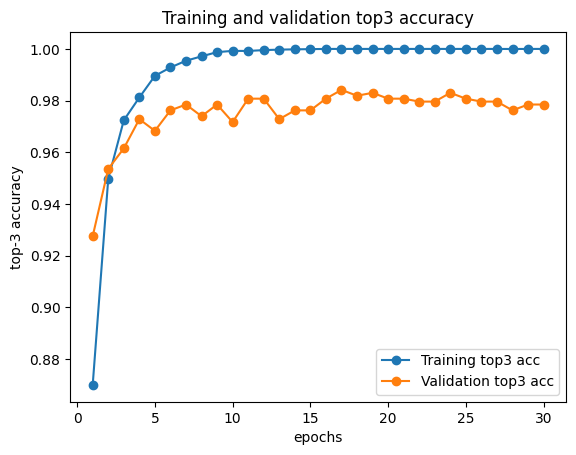

<Figure size 640x480 with 0 Axes>

In [17]:
# display the accuracy, top-2 accuracy and top-3 accuracy

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "-o", label='Training loss')
plt.plot(epochs, val_loss, "-o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.figure()
plt.savefig('loss.png', dpi=300)
plt.figure()

plt.plot(epochs, acc, "-o", label='Training cat acc')
plt.plot(epochs, val_acc, "-o", label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.figure()
plt.savefig('acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top2_acc, "-o", label='Training top2 acc')
plt.plot(epochs, val_top2_acc, "-o", label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-2 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top2acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top3_acc, "-o", label='Training top3 acc')
plt.plot(epochs, val_top3_acc, "-o", label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-3 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top3acc.png', dpi=300)
plt.figure()

In [18]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curves_from_generator(predictions, test_labels, class_names):
    """
    Plot ROC curves for predictions from a generator-based model.
    
    Parameters:
    predictions: Raw predictions from model.predict()
    test_labels: True labels from generator.classes
    class_names: List of class names in order matching generator.class_indices
    """
    # Convert predictions to probabilities if not already
    if len(predictions.shape) == 1:  # If predictions are already argmaxed
        # Convert to one-hot
        n_classes = len(class_names)
        y_pred_proba = np.zeros((len(predictions), n_classes))
        for i, pred in enumerate(predictions):
            y_pred_proba[i, pred] = 1
    else:
        y_pred_proba = predictions
    
    # Binarize the labels
    y_test_bin = label_binarize(test_labels, classes=range(len(class_names)))
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Store AUC scores
    auc_scores = {}
    
    # Plot ROC curve for each class
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[class_names[i]] = roc_auc
        
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    return plt.gcf(), auc_scores

# Best Model Based on Validation Categorical Accuracy

In [19]:
tl_model.load_weights('best_model.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [20]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - categorical_accuracy: 0.7593 - f1_score: 0.7557 - loss: 2.2773 - precision: 0.7580 - recall: 0.7535 - top_2_accuracy: 0.8898 - top_3_accuracy: 0.9547
val_loss: 1.5080069303512573
val_cat_acc: 0.8776897192001343
val_top_2_acc: 0.9513023495674133
val_top_3_acc: 0.9807474613189697
val_precision: 0.8787327408790588
val_recall: 0.8758096694946289
val_f1_score 0.8772596120834351


In [21]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [22]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

 1/18 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - categorical_accuracy: 0.4844 - f1_score: 0.4921 - loss: 3.5211 - precision: 0.5000 - recall: 0.4844 - top_2_accuracy: 0.7969 - top_3_accuracy: 0.8906

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - categorical_accuracy: 0.7457 - f1_score: 0.7495 - loss: 2.0969 - precision: 0.7534 - recall: 0.7457 - top_2_accuracy: 0.8983 - top_3_accuracy: 0.9602
test_loss: 1.4485673904418945
test_cat_acc: 0.8667271137237549
test_top_2_acc: 0.9501360058784485
test_top_3_acc: 0.9818676114082336
test_precision: 0.8720533847808838
test_recall: 0.8667245507240295
test_f1_score 0.8693583607673645


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step

AUC Scores per class:
akiec: 0.953
bcc: 0.983
bkl: 0.956
df: 0.940
mel: 0.912
nv: 0.969
vasc: 0.999


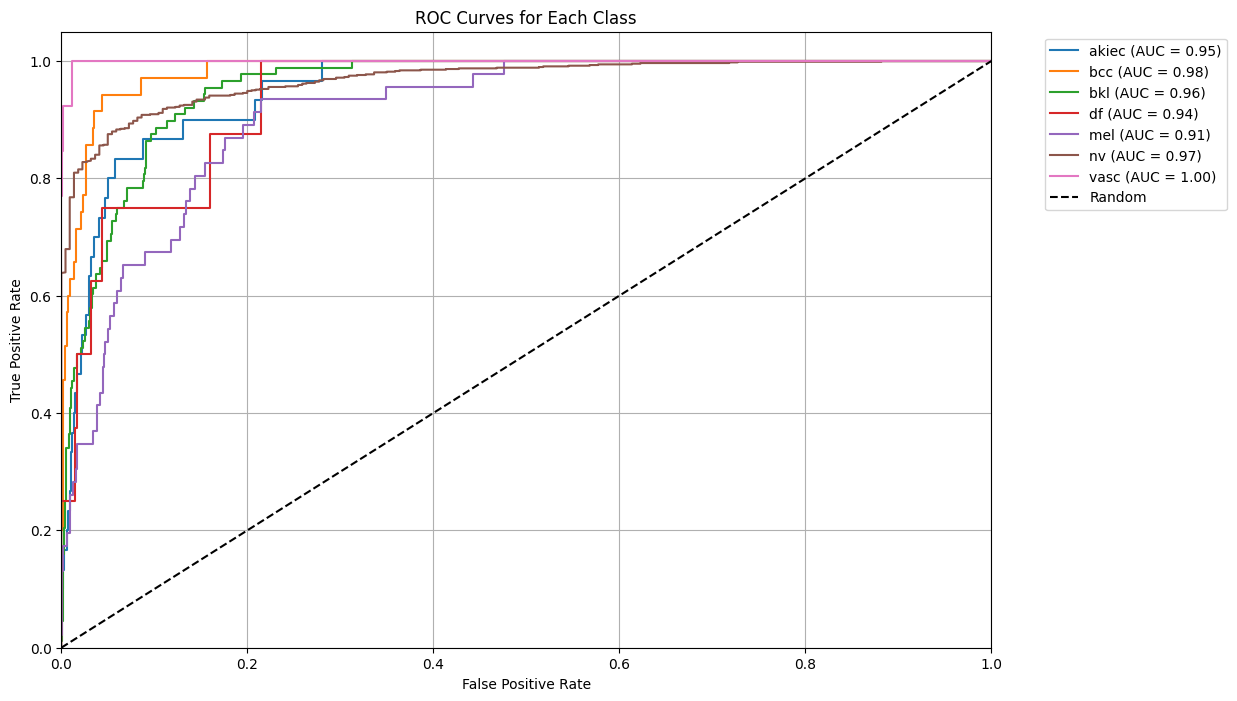

In [23]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves.png', bbox_inches='tight', dpi=300)
plt.close()

In [24]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step


Normalized confusion matrix
[[0.36666667 0.06666667 0.2        0.         0.13333333 0.23333333
  0.        ]
 [0.14285714 0.57142857 0.14285714 0.         0.         0.14285714
  0.        ]
 [0.06818182 0.01136364 0.54545455 0.01136364 0.15909091 0.20454545
  0.        ]
 [0.         0.125      0.125      0.25       0.         0.5
  0.        ]
 [0.02173913 0.02173913 0.08695652 0.         0.34782609 0.52173913
  0.        ]
 [0.00226501 0.00453001 0.01698754 0.00339751 0.01132503 0.9603624
  0.0011325 ]
 [0.         0.         0.         0.         0.         0.15384615
  0.84615385]]


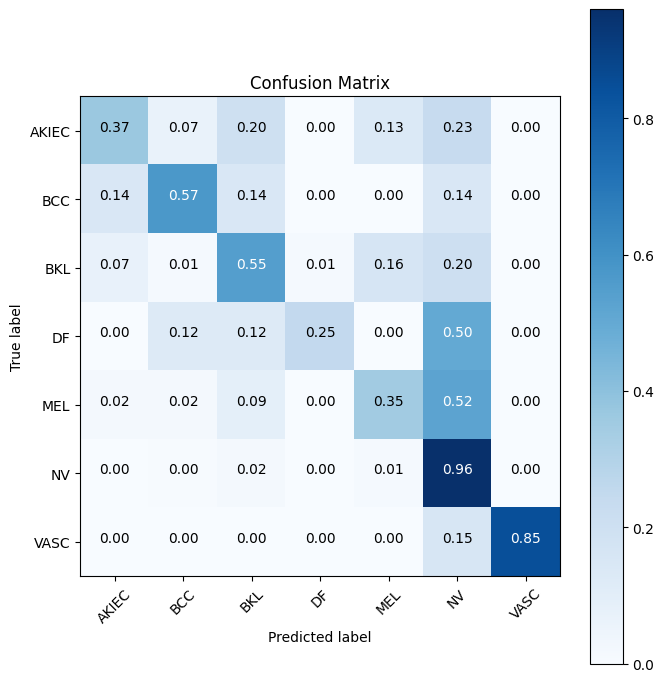

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [26]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.970082,0.978241,0.935630,0.990934,0.947416,0.913871,0.997280,0.961922
f1,0.400000,0.625000,0.574850,0.285714,0.355556,0.946957,0.880000,0.866727
false_discovery_rate,0.560000,0.310345,0.392405,0.666667,0.636364,0.066079,0.083333,0.133273
false_negative_rate,0.633333,0.428571,0.454545,0.750000,0.652174,0.039638,0.153846,0.133273
false_positive_rate,0.013048,0.008427,0.030542,0.003653,0.026490,0.272727,0.000917,0.022212
negative_predictive_value,0.982375,0.986034,0.960938,0.994531,0.971671,0.820513,0.998167,0.977788
positive_predictive_value,0.440000,0.689655,0.607595,0.333333,0.363636,0.933921,0.916667,0.866727
precision,0.440000,0.689655,0.607595,0.333333,0.363636,0.933921,0.916667,0.866727
recall,0.366667,0.571429,0.545455,0.250000,0.347826,0.960362,0.846154,0.866727
sensitivity,0.366667,0.571429,0.545455,0.250000,0.347826,0.960362,0.846154,0.866727


# Best Model Based on Validation Loss

In [27]:
tl_model.load_weights('val_loss_epoch.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [28]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - categorical_accuracy: 0.7574 - f1_score: 0.7605 - loss: 1.7974 - precision: 0.7636 - recall: 0.7574 - top_2_accuracy: 0.8981 - top_3_accuracy: 0.9530
val_loss: 1.0606974363327026
val_cat_acc: 0.8640996813774109
val_top_2_acc: 0.9524348974227905
val_top_3_acc: 0.9784824252128601
val_precision: 0.8687577843666077
val_recall: 0.8646489381790161
val_f1_score 0.8666785359382629


In [29]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [30]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - categorical_accuracy: 0.7508 - f1_score: 0.7520 - loss: 1.6781 - precision: 0.7583 - recall: 0.7461 - top_2_accuracy: 0.8895 - top_3_accuracy: 0.9488
test_loss: 1.016115427017212
test_cat_acc: 0.8631006479263306
test_top_2_acc: 0.9474161267280579
test_top_3_acc: 0.9755213260650635
test_precision: 0.8727479577064514
test_recall: 0.8663194179534912
test_f1_score 0.8694747090339661


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step

AUC Scores per class:
akiec: 0.951
bcc: 0.976
bkl: 0.941
df: 0.947
mel: 0.905
nv: 0.963
vasc: 1.000


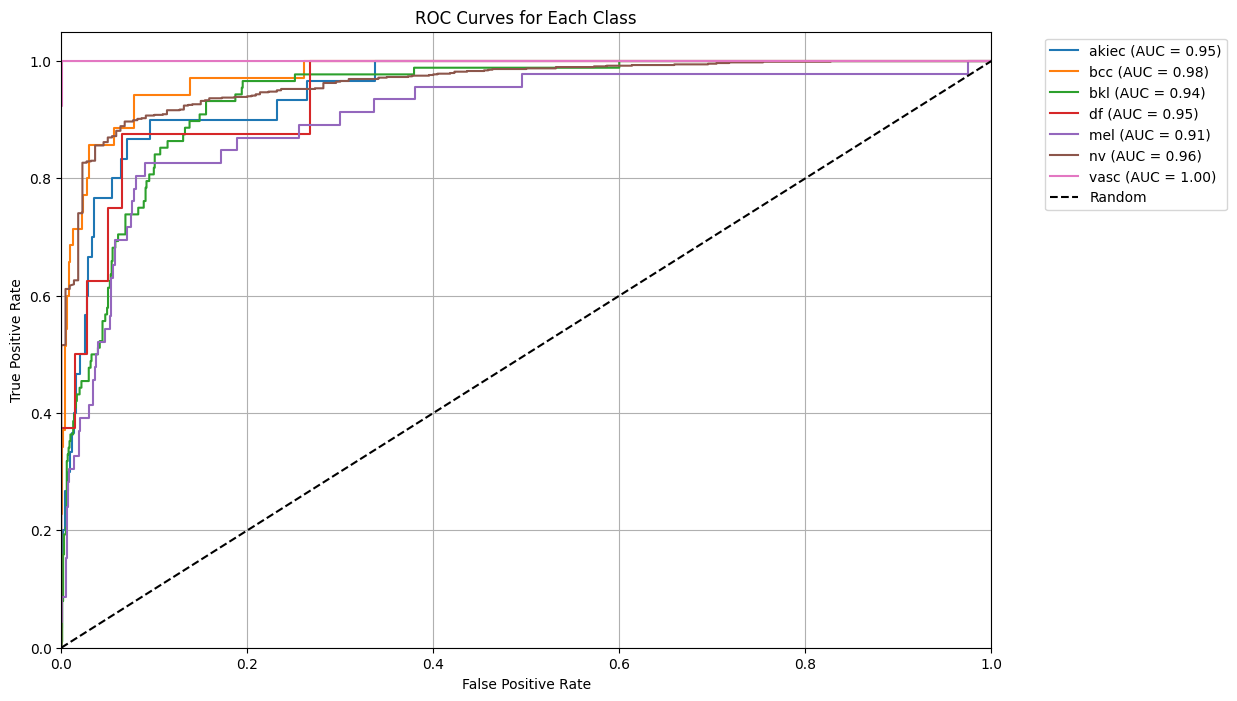

In [31]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves_valloss.png', bbox_inches='tight', dpi=300)
plt.close()

In [32]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


Normalized confusion matrix
[[0.36666667 0.13333333 0.23333333 0.         0.13333333 0.13333333
  0.        ]
 [0.14285714 0.68571429 0.11428571 0.         0.         0.05714286
  0.        ]
 [0.05681818 0.01136364 0.48863636 0.01136364 0.15909091 0.27272727
  0.        ]
 [0.         0.         0.125      0.375      0.         0.5
  0.        ]
 [0.02173913 0.02173913 0.10869565 0.         0.43478261 0.41304348
  0.        ]
 [0.00226501 0.00453001 0.02151755 0.0011325  0.02038505 0.94903737
  0.0011325 ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


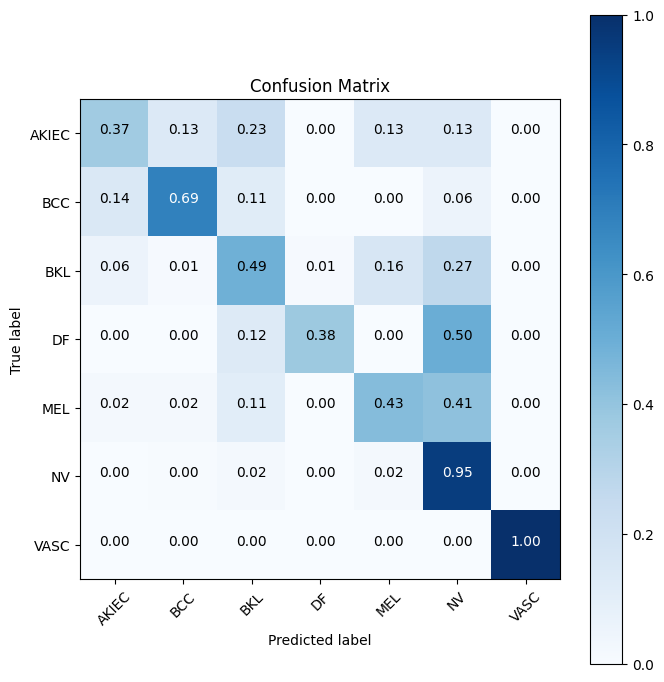

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix_valloss.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [34]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.970988,0.980961,0.926564,0.993654,0.943790,0.911151,0.999093,0.960886
f1,0.407407,0.695652,0.514970,0.461538,0.392157,0.944758,0.962963,0.863101
false_discovery_rate,0.541667,0.294118,0.455696,0.400000,0.642857,0.059484,0.071429,0.136899
false_negative_rate,0.633333,0.314286,0.511364,0.625000,0.565217,0.050963,0.000000,0.136899
false_positive_rate,0.012116,0.009363,0.035468,0.001826,0.034059,0.240909,0.000917,0.022817
negative_predictive_value,0.982391,0.989710,0.956055,0.995446,0.975167,0.787736,1.000000,0.977183
positive_predictive_value,0.458333,0.705882,0.544304,0.600000,0.357143,0.940516,0.928571,0.863101
precision,0.458333,0.705882,0.544304,0.600000,0.357143,0.940516,0.928571,0.863101
recall,0.366667,0.685714,0.488636,0.375000,0.434783,0.949037,1.000000,0.863101
sensitivity,0.366667,0.685714,0.488636,0.375000,0.434783,0.949037,1.000000,0.863101
